# Grid synthetic airborne survey with iterative equivalent layer

**Import useful packages**

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from boost_and_layouts import (
    block_averaged_sources,
    combine_parameters,
    EQLHarmonicBoost,
    save_to_json,
)


**Define results directory**

In [2]:
results_dir = Path("..") / "results"
airborne_results_dir = results_dir / "airborne_survey"
eql_boost_results_dir = results_dir / "eql-boost"

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Define which field will be meassured**

In [3]:
field = "g_z"
field_units = "mGal"

## Read synthetic airborne survey and target grid

Read airborne survey

In [4]:
survey = pd.read_csv(airborne_results_dir / "survey.csv")
survey

,longitude,latitude,height,easting,northing,g_z
0,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.654625
1,-0.495559,0.497999,644.0,-55165.348426,55066.630053,2.503813
2,-0.493218,0.497479,646.0,-54904.787861,55009.113126,2.873545
3,-0.482725,0.497679,663.0,-53736.719343,55031.235020,3.125810
4,-0.478464,0.497719,672.0,-53262.365493,55035.659399,4.717045
...,...,...,...,...,...,...
5668,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,10.041573
5669,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.431621
5670,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,14.078125
5671,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,15.672714


Read target grid

In [5]:
target = xr.open_dataarray(results_dir / "target.nc")
target

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray (northing: 56, easting: 57)>
array([[2.942098, 3.335356, 3.699304, ..., 3.534445, 3.187211, 2.824452],
       [3.334727, 3.805254, 4.23806 , ..., 4.003668, 3.594596, 3.165999],
       [3.697873, 4.237236, 4.731814, ..., 4.442474, 3.976724, 3.488055],
       ...,
       [4.113125, 4.720134, 5.285468, ..., 4.744527, 4.237688, 3.711379],
       [3.717267, 4.247201, 4.740353, ..., 4.301227, 3.852887, 3.387261],
       [3.293559, 3.739541, 4.155882, ..., 3.821831, 3.437721, 3.039456]])
Coordinates:
  * northing  (northing) float64 -5.529e+04 -5.329e+04 ... 5.271e+04 5.471e+04
  * easting   (easting) float64 -5.566e+04 -5.366e+04 ... 5.434e+04 5.634e+04
Attributes:
    height:   2000

Define coordiantes tuple with the location of the survey points

In [6]:
coordinates = (survey.easting.values, survey.northing.values, survey.height.values)

Get region of the target grid

In [7]:
region = (
    target.easting.min().values,
    target.easting.max().values,
    target.northing.min().values,
    target.northing.max().values,
)

## Grid data with EQLHarmonicBoost


### Use a window size of 20km

Define gridding parameters

In [8]:
depth_type = "relative_depth"
random_state = int(0)
block_spacing = 2e3
dampings = np.logspace(-6, 1, 8)
depths = np.arange(1e3, 20e3, 2e3)
window_size = 20e3

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Combine parameters values

In [9]:
parameters = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=block_spacing,
        window_size=window_size,
        random_state=random_state,
    )
)

Dump parameters to a JSON file

In [10]:
json_file = eql_boost_results_dir / "parameters-20km.json"
save_to_json(parameters, json_file)

Grid and score the prediction with each set of parameters

In [11]:
rms = []
for params in parameters:
    points = block_averaged_sources(coordinates, **params)
    eql = EQLHarmonicBoost(
        points=points,
        damping=params["damping"],
        window_size=params["window_size"],
        random_state=params["random_state"],
    )
    eql.fit(coordinates, getattr(survey, field).values)
    grid = eql.grid(upward=target.height, region=region, shape=target.shape).scalars
    rms.append(np.sqrt(mean_squared_error(grid.values, target.values)))

Get maximum score and the corresponding set of parameters

In [12]:
best_rms = np.min(rms)
best_params = parameters[np.argmin(rms)]

print("Best RMS score: {}".format(best_rms))
print("Best parameters: {}".format(best_params))

Best RMS score: 0.4140514116691438
Best parameters: {'depth_type': 'relative_depth', 'depth': 3000.0, 'damping': 0.1, 'spacing': 2000.0, 'window_size': 20000.0, 'random_state': 0}


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Obtain grid with the best set of parameters

In [13]:
points = block_averaged_sources(coordinates, **best_params)
eql = EQLHarmonicBoost(
    points=points,
    damping=best_params["damping"],
    window_size=best_params["window_size"],
    random_state=best_params["random_state"],
)

RMS: 0.4140514116691438


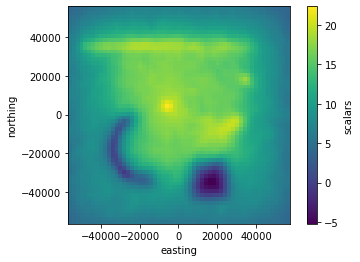

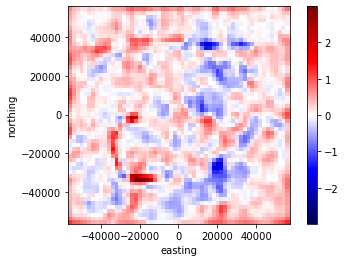

In [14]:
eql.fit(coordinates, getattr(survey, field).values)
grid = eql.grid(upward=target.height, region=region, shape=target.shape).scalars

print("RMS: {}".format(np.sqrt(mean_squared_error(grid.values, target.values))))
grid.plot(center=False)
plt.gca().set_aspect("equal")
plt.show()


maxabs = vd.maxabs(grid - target)
(grid - target).plot(cmap="seismic", vmin=-maxabs, vmax=maxabs)
plt.gca().set_aspect("equal")
plt.show()

Plot misfit through the iterations

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


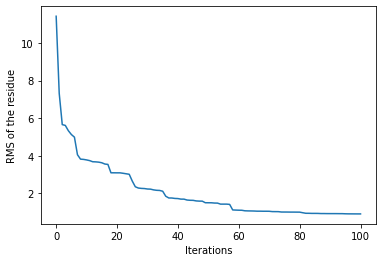

In [15]:
plt.plot(eql.errors_)
plt.xlabel("Iterations")
plt.ylabel("RMS of the residue")
plt.show()

Save grid

In [16]:
grid.to_netcdf(eql_boost_results_dir / "airborne_grid_boost_20km.nc")

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Use a window size of 50km

In [17]:
dampings = np.logspace(-4, 3, 8)
depths = [100, 500, 1e3, 2e3, 5e3, 10e3]
window_size = 50e3

Combine parameters values

In [18]:
parameters = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=block_spacing,
        window_size=window_size,
        random_state=random_state,
    )
)

Dump parameters to a JSON file

In [19]:
json_file = eql_boost_results_dir / "parameters-50km.json"
save_to_json(parameters, json_file)

Grid and score the prediction with each set of parameters

In [20]:
rms = []
for params in parameters:
    points = block_averaged_sources(coordinates, **params)
    eql = EQLHarmonicBoost(
        points=points,
        damping=params["damping"],
        window_size=params["window_size"],
        random_state=params["random_state"],
    )
    eql.fit(coordinates, getattr(survey, field).values)
    grid = eql.grid(upward=target.height, region=region, shape=target.shape).scalars
    rms.append(np.sqrt(mean_squared_error(grid.values, target.values)))

Get maximum score and the corresponding set of parameters

In [21]:
best_rms = np.min(rms)
best_params = parameters[np.argmin(rms)]

print("Best RMS score: {}".format(best_rms))
print("Best parameters: {}".format(best_params))

Best RMS score: 0.43478787017671844
Best parameters: {'depth_type': 'relative_depth', 'depth': 5000.0, 'damping': 0.1, 'spacing': 2000.0, 'window_size': 50000.0, 'random_state': 0}


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Obtain grid with the best set of parameters

In [22]:
points = block_averaged_sources(coordinates, **best_params)
eql = EQLHarmonicBoost(
    points=points,
    damping=best_params["damping"],
    window_size=best_params["window_size"],
    random_state=best_params["random_state"],
)

RMS: 0.43478787017671844


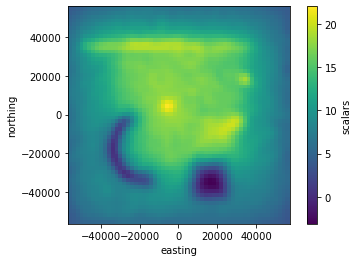

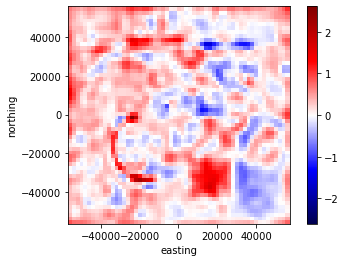

In [23]:
eql.fit(coordinates, getattr(survey, field).values)
grid = eql.grid(upward=target.height, region=region, shape=target.shape).scalars

print("RMS: {}".format(np.sqrt(mean_squared_error(grid.values, target.values))))
grid.plot(center=False)
plt.gca().set_aspect("equal")
plt.show()


maxabs = vd.maxabs(grid - target)
(grid - target).plot(cmap="seismic", vmin=-maxabs, vmax=maxabs)
plt.gca().set_aspect("equal")
plt.show()

Plot misfit through the iterations

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


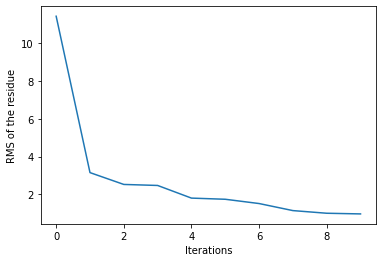

In [24]:
plt.plot(eql.errors_)
plt.xlabel("Iterations")
plt.ylabel("RMS of the residue")
plt.show()

Save grid

In [25]:
grid.to_netcdf(eql_boost_results_dir / "airborne_grid_boost_50km.nc")

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
